In [1]:
# Import project and set a symbolic link in /content

import os
from google.colab import drive
drive.mount('/content/gdrive')

# set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/bayesian-privacy'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/bayesian-privacy'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

## Move in the project directory
%cd /content/bayesian-privacy
!pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/bayesian-differential-privacy-master
/content/gdrive/My Drive/bayesian-differential-privacy-master


In [9]:
%reload_ext autoreload
%autoreload 2

import itertools
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from bayesian_privacy_accountant import BayesianPrivacyAccountant

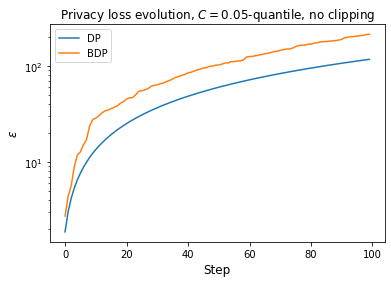

In [13]:
ma_eps = []
ba_eps = []

quant = 0.05
sigma = 1.0
plot_range = np.arange(100)

moment_accountant = BayesianPrivacyAccountant(powers=16, total_steps=plot_range[-1]+1, bayesianDP=False)
bayes_accountant = BayesianPrivacyAccountant(powers=16, total_steps=plot_range[-1]+1)
for i in plot_range:
    grads = np.random.weibull(0.5, [50, 1000])
    C = np.quantile(np.linalg.norm(grads, axis=1), quant)
    #grads /= np.maximum(1, np.linalg.norm(grads, axis=1, keepdims=True) / C)
    
    moment_accountant.accumulate(
        ldistr=(C*2, sigma * C * 2), # multiply by 2, because 2C is the actual max distance
        rdistr=(0, sigma * C * 2),
        q=1/1000, 
        steps=1
    )
    ma_eps += [moment_accountant.get_privacy(target_delta=1e-5)[0]]
    pairs = list(zip(*itertools.combinations(torch.tensor(grads), 2)))
    bayes_accountant.accumulate(
        ldistr=(torch.stack(pairs[0]), sigma * C * 2), 
        rdistr=(torch.stack(pairs[1]), sigma * C * 2), 
        #ldistr=(torch.tensor(grads[:25]), sigma * C * 2), 
        #rdistr=(torch.tensor(grads[25:]), sigma * C * 2), 
        q=1/1000, 
        steps=1
    ) 
    ba_eps += [bayes_accountant.get_privacy(target_delta=1e-5)[0]]

plt.plot(plot_range, ma_eps, label='DP')
plt.plot(plot_range, ba_eps, label='BDP')
plt.yscale('log')
plt.legend()
plt.xlabel(r'Step', fontsize=12)
plt.ylabel(r'$\varepsilon$', fontsize=12)
plt.title(r'Privacy loss evolution, $C=0.05$-quantile, no clipping', fontsize=12)
plt.savefig('eps_step_05q_noclip.pdf', format='pdf', bbox_inches='tight')

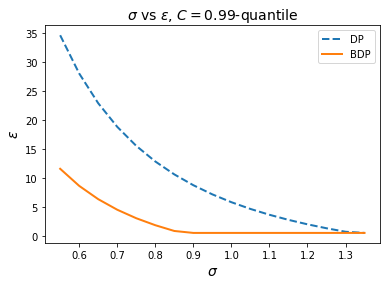

In [4]:
grads = np.random.weibull(0.5, [50, 1000])

quant = 0.99
C = np.quantile(np.linalg.norm(grads, axis=1), quant)
grads /= np.maximum(1, np.linalg.norm(grads, axis=1, keepdims=True) / C)

ma_eps = []
ba_eps = []
sigmas = np.arange(0.55, 1.4, 0.05)
for sigma in sigmas:
    moment_accountant = BayesianPrivacyAccountant(powers=24, total_steps=1, bayesianDP=False)
    moment_accountant.accumulate(ldistr=(C * 2, sigma * C * 2), rdistr=(0, sigma * C * 2), q=1/1000, steps=1)
    ma_eps += [moment_accountant.get_privacy(target_delta=1e-5)[0]]
    
    bayes_accountant = BayesianPrivacyAccountant(powers=24, total_steps=1)
    pairs = list(zip(*itertools.combinations(torch.tensor(grads), 2)))
    bayes_accountant.accumulate(
        ldistr=(torch.stack(pairs[0]), sigma * C * 2), 
        rdistr=(torch.stack(pairs[1]), sigma * C * 2), 
        q=1/1000, 
        steps=1
    ) 
    ba_eps += [bayes_accountant.get_privacy(target_delta=1e-5)[0]]

plt.rc('axes', titlesize=14, labelsize=14)
plt.plot(sigmas, ma_eps, '--', linewidth=2, label='DP')
plt.plot(sigmas, ba_eps, linewidth=2, label='BDP')
plt.legend()
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\varepsilon$')
plt.title(r'$\sigma$ vs $\varepsilon$, $C=0.99$-quantile')
plt.savefig('eps_sigma_99q.pdf', format='pdf', bbox_inches='tight')

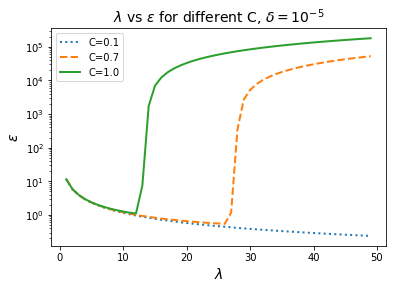

In [5]:
ba_eps = []

sigma = 1.0
plot_range = range(1, 50)

ba_eps_c = []
for C in [0.1, 0.7, 1.0]:
    grads = np.random.randn(50, 1000)
    grads /= np.maximum(1, np.linalg.norm(grads, axis=1, keepdims=True) / C)
    ba_eps = []
    for p in plot_range: 
        bayes_accountant = BayesianPrivacyAccountant(powers=p, total_steps=10000, bayesianDP=False)
        bayes_accountant.accumulate(ldistr=(C, sigma), rdistr=(0, sigma), q=64/60000, steps=10000)
        ba_eps += [bayes_accountant.get_privacy(target_delta=1e-5)[0]]
    ba_eps_c += [ba_eps]

plt.rc('axes', titlesize=14, labelsize=14)
plt.plot(plot_range, ba_eps_c[0], ':', linewidth=2, label='C=0.1')
plt.plot(plot_range, ba_eps_c[1], '--', linewidth=2, label='C=0.7')
plt.plot(plot_range, ba_eps_c[2], '-', linewidth=2, label='C=1.0')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\varepsilon$')
plt.title(r'$\lambda$ vs $\varepsilon$ for different C, $\delta=10^{-5}$')
plt.savefig('eps_lambda_C.pdf', format='pdf', bbox_inches='tight')